In [19]:
# use the GPU if available
import tensorflow as tf

configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [20]:
import sys
import tensorflow.keras as keras


In [21]:
# Import the necessary packages

import pandas as pd
import numpy as np
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import model_from_json
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
#

In [22]:
# download the dataset from https://www.kaggle.com/c/diabetic-retinopathy-detection/data?select=train.zip.001
# Since the whole dataset size is large, we will use the train.zip.001 (~8GB) in this noteboo.
SEED = 42
BATCH_SIZE = 16
IMG_HEIGHT = 224
IMG_WIDTH = 224
LABELS = ['mild','moderate','No_DR','Prolfriate_DR','sever']

images = os.listdir('./train')
leb = pd.read_csv('trainLabels.csv')


In [23]:
# proceses the labels
Labels = pd.read_csv('trainLabels.csv');
Label_ = [list(Labels.level[Labels.image == img[:-5]]) for img in images]

#flatten the list
Label_ = list(np.array(Label_).flatten())


Labels =  [LABELS[i] for i in Label_]


<AxesSubplot:ylabel='count'>

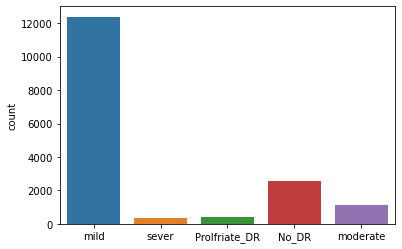

In [24]:
# see the distribution of the data
sns.countplot(Labels)

In [25]:
# build the dataframe
train = os.listdir('./train')
print('Number of train images : {} \n'.format(len(train)))

d = {'Images': train, 'Labels': Labels}
Alldata = pd.DataFrame(data=d)
Alldata

Number of train images : 16802 



,Images,Labels
0,10003_left.jpeg,mild
1,10003_right.jpeg,mild
2,10007_left.jpeg,mild
3,10007_right.jpeg,mild
4,10009_left.jpeg,mild
...,...,...
16797,29117_right.jpeg,mild
16798,2911_left.jpeg,mild
16799,2911_right.jpeg,mild
16800,29126_left.jpeg,No_DR


In [26]:
# Shuffle the data and split it into training and testing
Alldata = shuffle(Alldata,random_state=  SEED)
train, testAndval = train_test_split(Alldata, test_size = 0.2,random_state=  SEED)

val, test = train_test_split(testAndval, test_size = 0.5,random_state = SEED)#


In [27]:
'''
# prepare the data suitale to process using the tf.data API
import os, shutil

os.makedirs('train_tf',exist_ok=True)

for ii in range(len(LABELS)):
    os.makedirs('./train_tf/'+ LABELS[ii],exist_ok=True)
    images = train.Images[train.Labels==LABELS[ii]]    
    for x in images: shutil.copyfile(os.path.join('./train', x), os.path.join('./train_tf', LABELS[ii],x)) 
  
for ii in range(len(LABELS)):
    os.makedirs('./val_tf/'+ LABELS[ii],exist_ok=True)
    images = val.Images[val.Labels==LABELS[ii]]    
    for x in images: shutil.copyfile(os.path.join('./train', x), os.path.join('./val_tf', LABELS[ii],x)) 

for ii in range(len(LABELS)):
    os.makedirs('./test_tf/'+ LABELS[ii],exist_ok=True)
    images = test.Images[test.Labels==LABELS[ii]]    
    for x in images: shutil.copyfile(os.path.join('./train', x), os.path.join('./test_tf', LABELS[ii],x)) 
'''

"\n# prepare the data suitale to process using the tf.data API\nimport os, shutil\n\nos.makedirs('train_tf',exist_ok=True)\n\nfor ii in range(len(LABELS)):\n    os.makedirs('./train_tf/'+ LABELS[ii],exist_ok=True)\n    images = train.Images[train.Labels==LABELS[ii]]    \n    for x in images: shutil.copyfile(os.path.join('./train', x), os.path.join('./train_tf', LABELS[ii],x)) \n  \nfor ii in range(len(LABELS)):\n    os.makedirs('./val_tf/'+ LABELS[ii],exist_ok=True)\n    images = val.Images[val.Labels==LABELS[ii]]    \n    for x in images: shutil.copyfile(os.path.join('./train', x), os.path.join('./val_tf', LABELS[ii],x)) \n\nfor ii in range(len(LABELS)):\n    os.makedirs('./test_tf/'+ LABELS[ii],exist_ok=True)\n    images = test.Images[test.Labels==LABELS[ii]]    \n    for x in images: shutil.copyfile(os.path.join('./train', x), os.path.join('./test_tf', LABELS[ii],x)) \n"

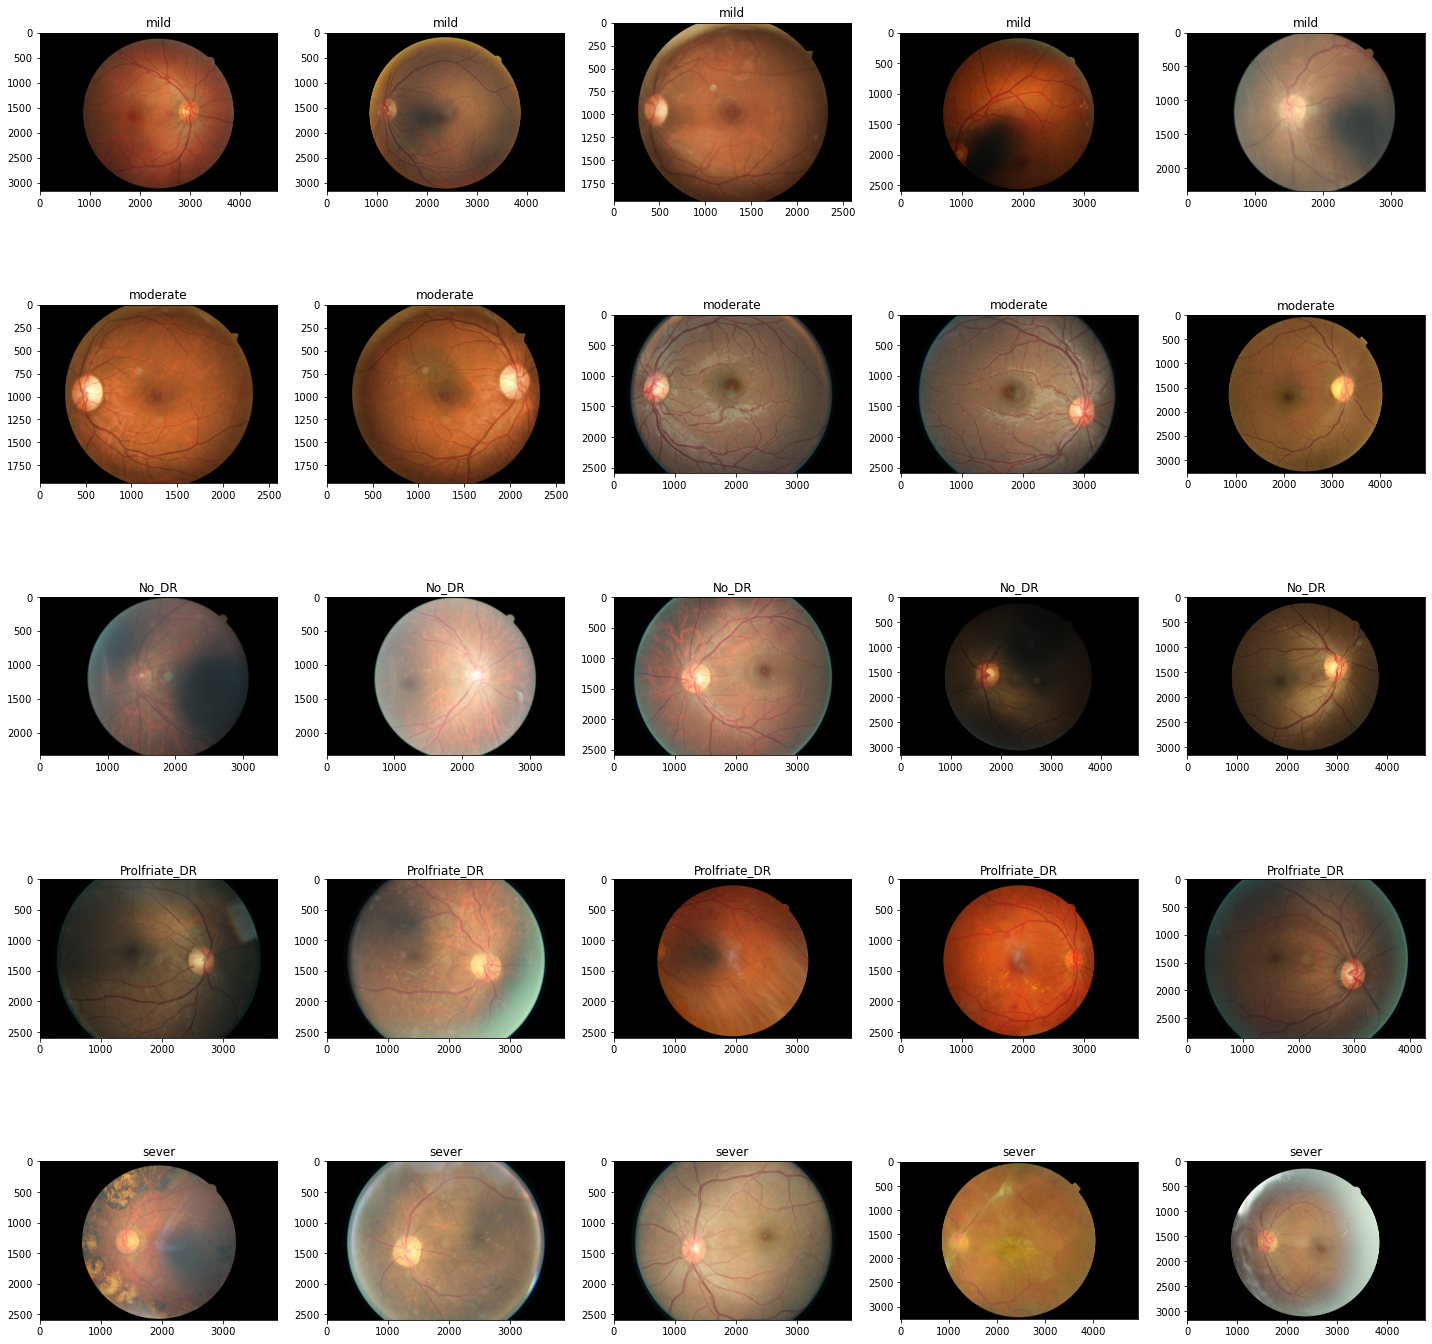

In [28]:
# Visualize 5 images for each class in the dataset
fig, ax = plt.subplots(5, 5, figsize = (20, 20))

for ii in range(5):    
    for jj in range(5): 
        imgs =  os.listdir(os.path.join('./train_tf', LABELS[ii]))
        img = PIL.Image.open(os.path.join('./train_tf', LABELS[ii],imgs[jj]))
        ax[ii,jj].title.set_text(LABELS[ii])
        ax[ii,jj].imshow(img)  
        
fig.tight_layout()

In [29]:
# we will use the tf.data.Dataset APi since it is relativly faster thatn the keras API
import pathlib
import tensorflow as tf


## train data
# ImageDataGenerator and Data Augmentations by using keras API
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range = 0.2,)

# Here we can define easily the parameters
train_data_gen = train_gen.flow_from_directory(
                    batch_size=BATCH_SIZE,
                                        directory='train_tf',
                                        shuffle=True,
                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        color_mode="rgb",
                                        class_mode= 'categorical',
                                        )

# And then wrapping the keras generator
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_data_gen,
    output_types=(tf.float32, tf.float32),
    output_shapes = ([None,IMG_HEIGHT,IMG_WIDTH,3],
                     [None,len(LABELS)]))



## Validation data ImageDataGenerator 
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

# Here we can define easily the parameters
val_data_gen = val_gen.flow_from_directory(
                                        directory='val_tf',
                                        shuffle=True,
                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        color_mode="rgb",
                                        class_mode= 'categorical',
                                        )

# And then wrapping the keras generator
val_dataset = tf.data.Dataset.from_generator(
    lambda: val_data_gen,
    output_types=(tf.float32, tf.float32))


## testdata ImageDataGenerator 
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

# Here we can define easily the parameters
test_data_gen = test_gen.flow_from_directory(
                                        directory='test_tf',
                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        shuffle=False, batch_size=1,color_mode="rgb", class_mode='categorical'
                                        )


Found 3503 images belonging to 5 classes.
Found 1680 images belonging to 5 classes.
Found 1681 images belonging to 5 classes.


In [30]:
# example of loading the resnet50 model
from tensorflow.keras.applications.resnet50 import ResNet50
# load model
resnet50 = ResNet50( include_top=False, weights="imagenet", input_shape= (IMG_HEIGHT, IMG_WIDTH, 3))

MobileNetV2 = tf.keras.applications.MobileNetV2(input_shape= (IMG_HEIGHT, IMG_WIDTH, 3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    pooling=None,
    classes=1000)

DenseNet121 = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape= (IMG_HEIGHT, IMG_WIDTH, 3),
    pooling=None,
    classes=1000,
)

pre_trained = DenseNet121
# add new classifier layers

inputs = pre_trained.input
outputs = pre_trained.layers[-1].output

model = Model(inputs=inputs, outputs=outputs)

model = Sequential([
        model,
        Conv2D( kernel_size = (3,3), strides =(2,2)))
        MaxPool2D((2,2))

        Conv2D( kernel_size = (3,3), strides =(2,2)))
        MaxPool2D((2,2))


        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.5),
        Dense(5, activation='sigmoid')
    ])


model.layers[0].trainable = False    


In [31]:
#resnet_model = ResNetModel()
#resnet_model = tf.keras.Sequential([ResNetModel(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="resent_model")])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2508850   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 255       
Total params: 9,546,609
Trainable params: 2,509,105
Non-trainable params: 7,037,504
_________________________________________________________________


In [32]:
# serialize model to JSON
model_json = model.to_json()
with open("model_json_pretrained.json", "w") as json_file:
    json_file.write(model_json)

<AxesSubplot:ylabel='count'>

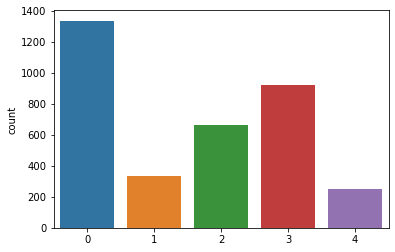

In [33]:
sns.countplot(train_data_gen.classes)

In [34]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_data_gen.classes),
                                                 train_data_gen.classes)

class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5247940074906366,
 1: 2.0789317507418397,
 2: 1.055120481927711,
 3: 0.7631808278867103,
 4: 2.8136546184738958}

In [17]:
#using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
#earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)

best_model = ModelCheckpoint('weights__TL.hdf5"', monitor='val_acc', mode='max',verbose=1, save_best_only=True)

history = model.fit(train_dataset, steps_per_epoch = train_data_gen.n // BATCH_SIZE,
                           epochs = 20, validation_data = val_dataset, validation_steps = val_data_gen.n // BATCH_SIZE,
                           callbacks=[ best_model])

Epoch 1/20
 84/218 [==========>...................] - ETA: 5:34 - loss: 2.8988 - accuracy: 0.3490

KeyboardInterrupt: 

In [ ]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    try:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    except KeyError:
        plt.plot(history.history['categorical_accuracy'])
        plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [ ]:
# Evaluate the result using confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

plt.figure(figsize=(10, 8))

# load weights into new model
loaded_model = tf.keras.Sequential([ResNetModel(input_shape=(256, 256, 3), name="resent_model")])

loaded_model.load_weights("weights__.hdf5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])


filenames = test_data_gen.filenames
nb_samples = len(filenames)
nb_samples
pred = loaded_model.predict_generator(test_data_gen,steps = nb_samples)

y_pred=np.argmax(pred,axis=1)


cm = confusion_matrix(test_data_gen.classes, y_pred)

LABELS_ = list(test_data_gen.class_indices.keys())

df_cm = pd.DataFrame(cm, index=LABELS_, columns=LABELS_)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted",fontsize = 20)
plt.xlabel("Actual",fontsize = 20)
plt.show()
#'''

